In [110]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
import calendar
from scipy.stats import linregress

data_dir = '/imerg_data'
files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.nc4')])
ds = xr.open_mfdataset(files, combine='by_coords')
print(ds)

<xarray.Dataset> Size: 213GB
Dimensions:                         (time: 1827, lon: 3600, lat: 1800, nv: 2)
Coordinates:
  * lat                             (lat) float64 14kB -89.95 -89.85 ... 89.95
  * lon                             (lon) float32 14kB -179.9 -179.9 ... 179.9
  * nv                              (nv) float32 8B 0.0 1.0
  * time                            (time) datetime64[ns] 15kB 2020-01-01 ......
Data variables:
    MWprecipitation                 (time, lon, lat) float32 47GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    precipitation_cnt_cond          (time, lon, lat) int8 12GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    precipitation                   (time, lon, lat) float32 47GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    MWprecipitation_cnt             (time, lon, lat) int8 12GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    MWprecipitation_cnt_cond        (time, lon, lat) int8 12GB dask.array<chunksize=(1,

In [46]:
lat_range = slice(20, 27.5)
lon_range = slice(85, 93)
region_ds = ds.sel(lat=lat_range, lon=lon_range)
precip = region_ds['precipitation'].transpose('time', 'lat', 'lon')
monthly_rain = precip.resample(time='1ME').sum()

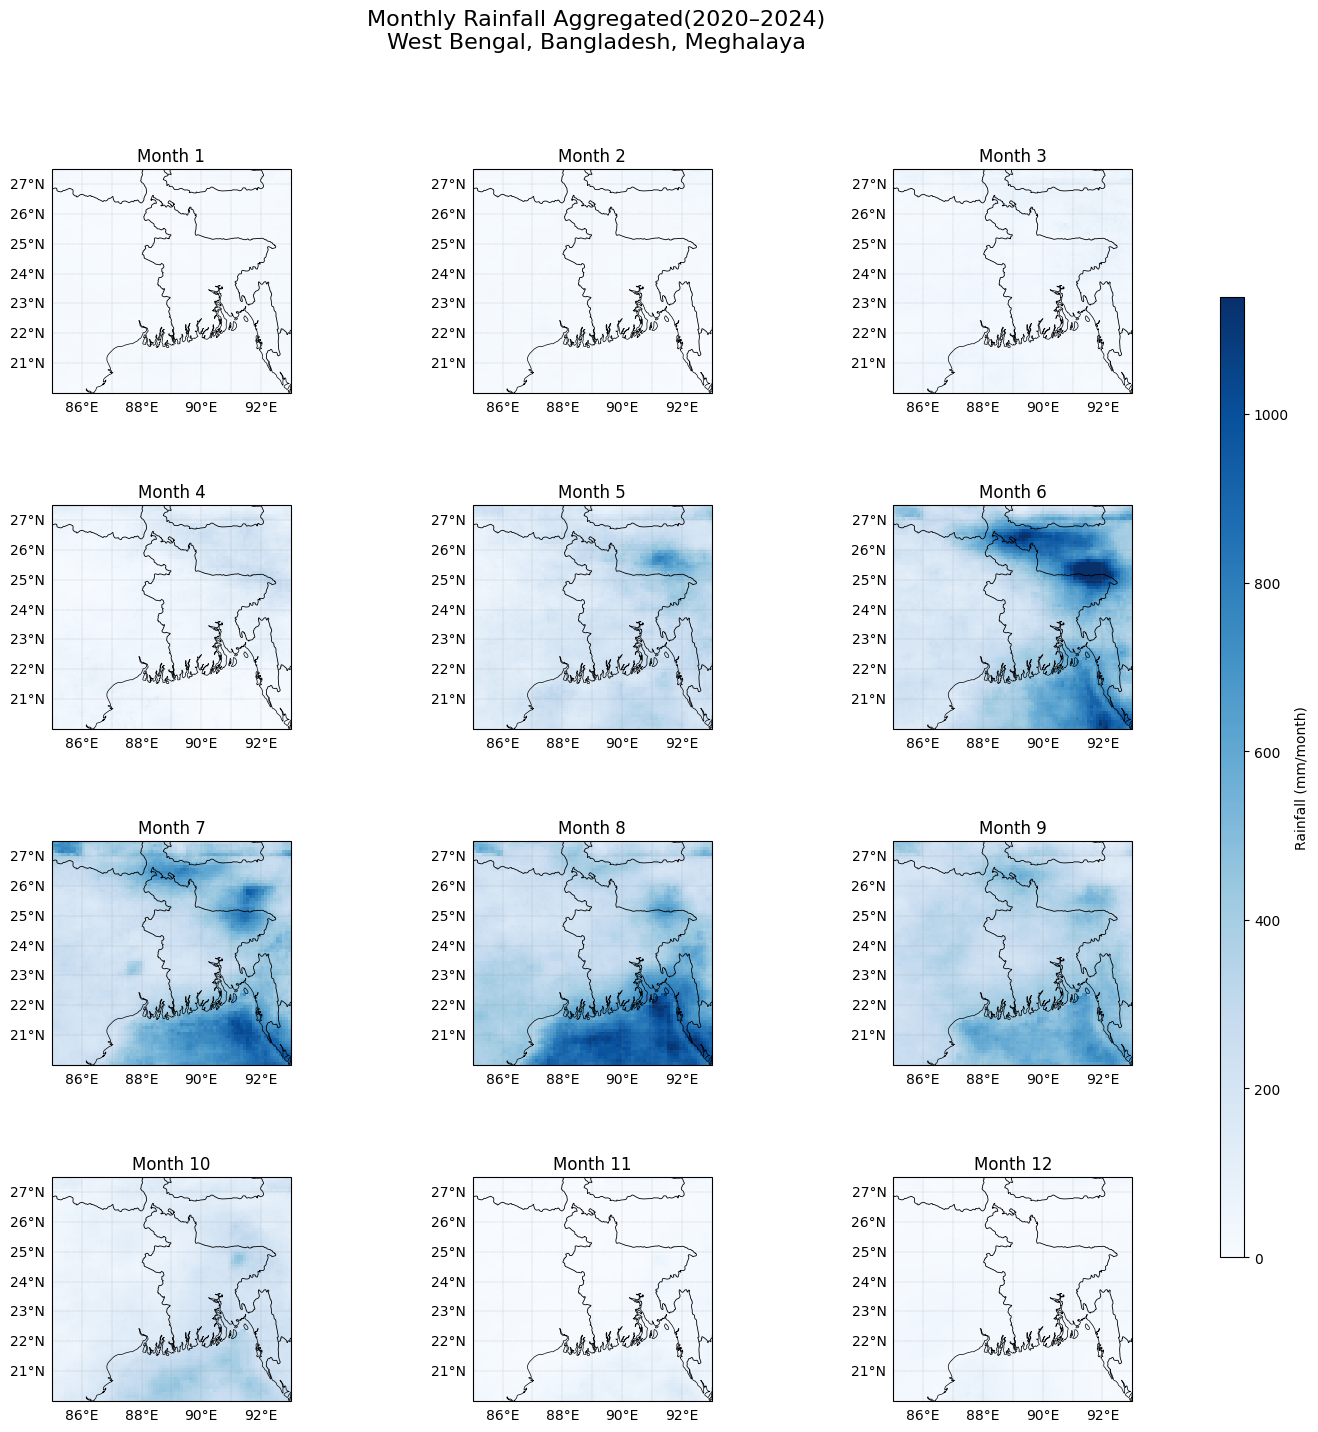

In [102]:
monthly_rainfall = monthly_rain.groupby('time.month').mean('time')
fig, axes = plt.subplots(4, 3, figsize=(16, 16), subplot_kw={'projection': ccrs.PlateCarree()})

flat_rain = monthly_rain.values.flatten()
flat_rain = flat_rain[~np.isnan(flat_rain)]
vmin = 0
vmax = np.percentile(flat_rain, 99)

for i, ax in enumerate(axes.flat):
    month_data = monthly_rainfall.isel(month=i)
    pcm = ax.pcolormesh(month_data.lon, month_data.lat, month_data,cmap='Blues', shading='auto',transform=ccrs.PlateCarree(), vmin = vmin, vmax = vmax)
    ax.set_extent([85, 93, 20, 27.5], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linewidth=0.6)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
    gl.right_labels = False 
    gl.top_labels = False
    ax.set_title(f'Month {i+1}')

plt.subplots_adjust(right=0.87, hspace=0.5)
cbar_ax = fig.add_axes([0.89, 0.2, 0.015, 0.6])
fig.colorbar(pcm, cax=cbar_ax, label='Rainfall (mm/month)')

fig.suptitle('Monthly Rainfall Aggregated(2020–2024)\nWest Bengal, Bangladesh, Meghalaya', fontsize=16)
plt.show()

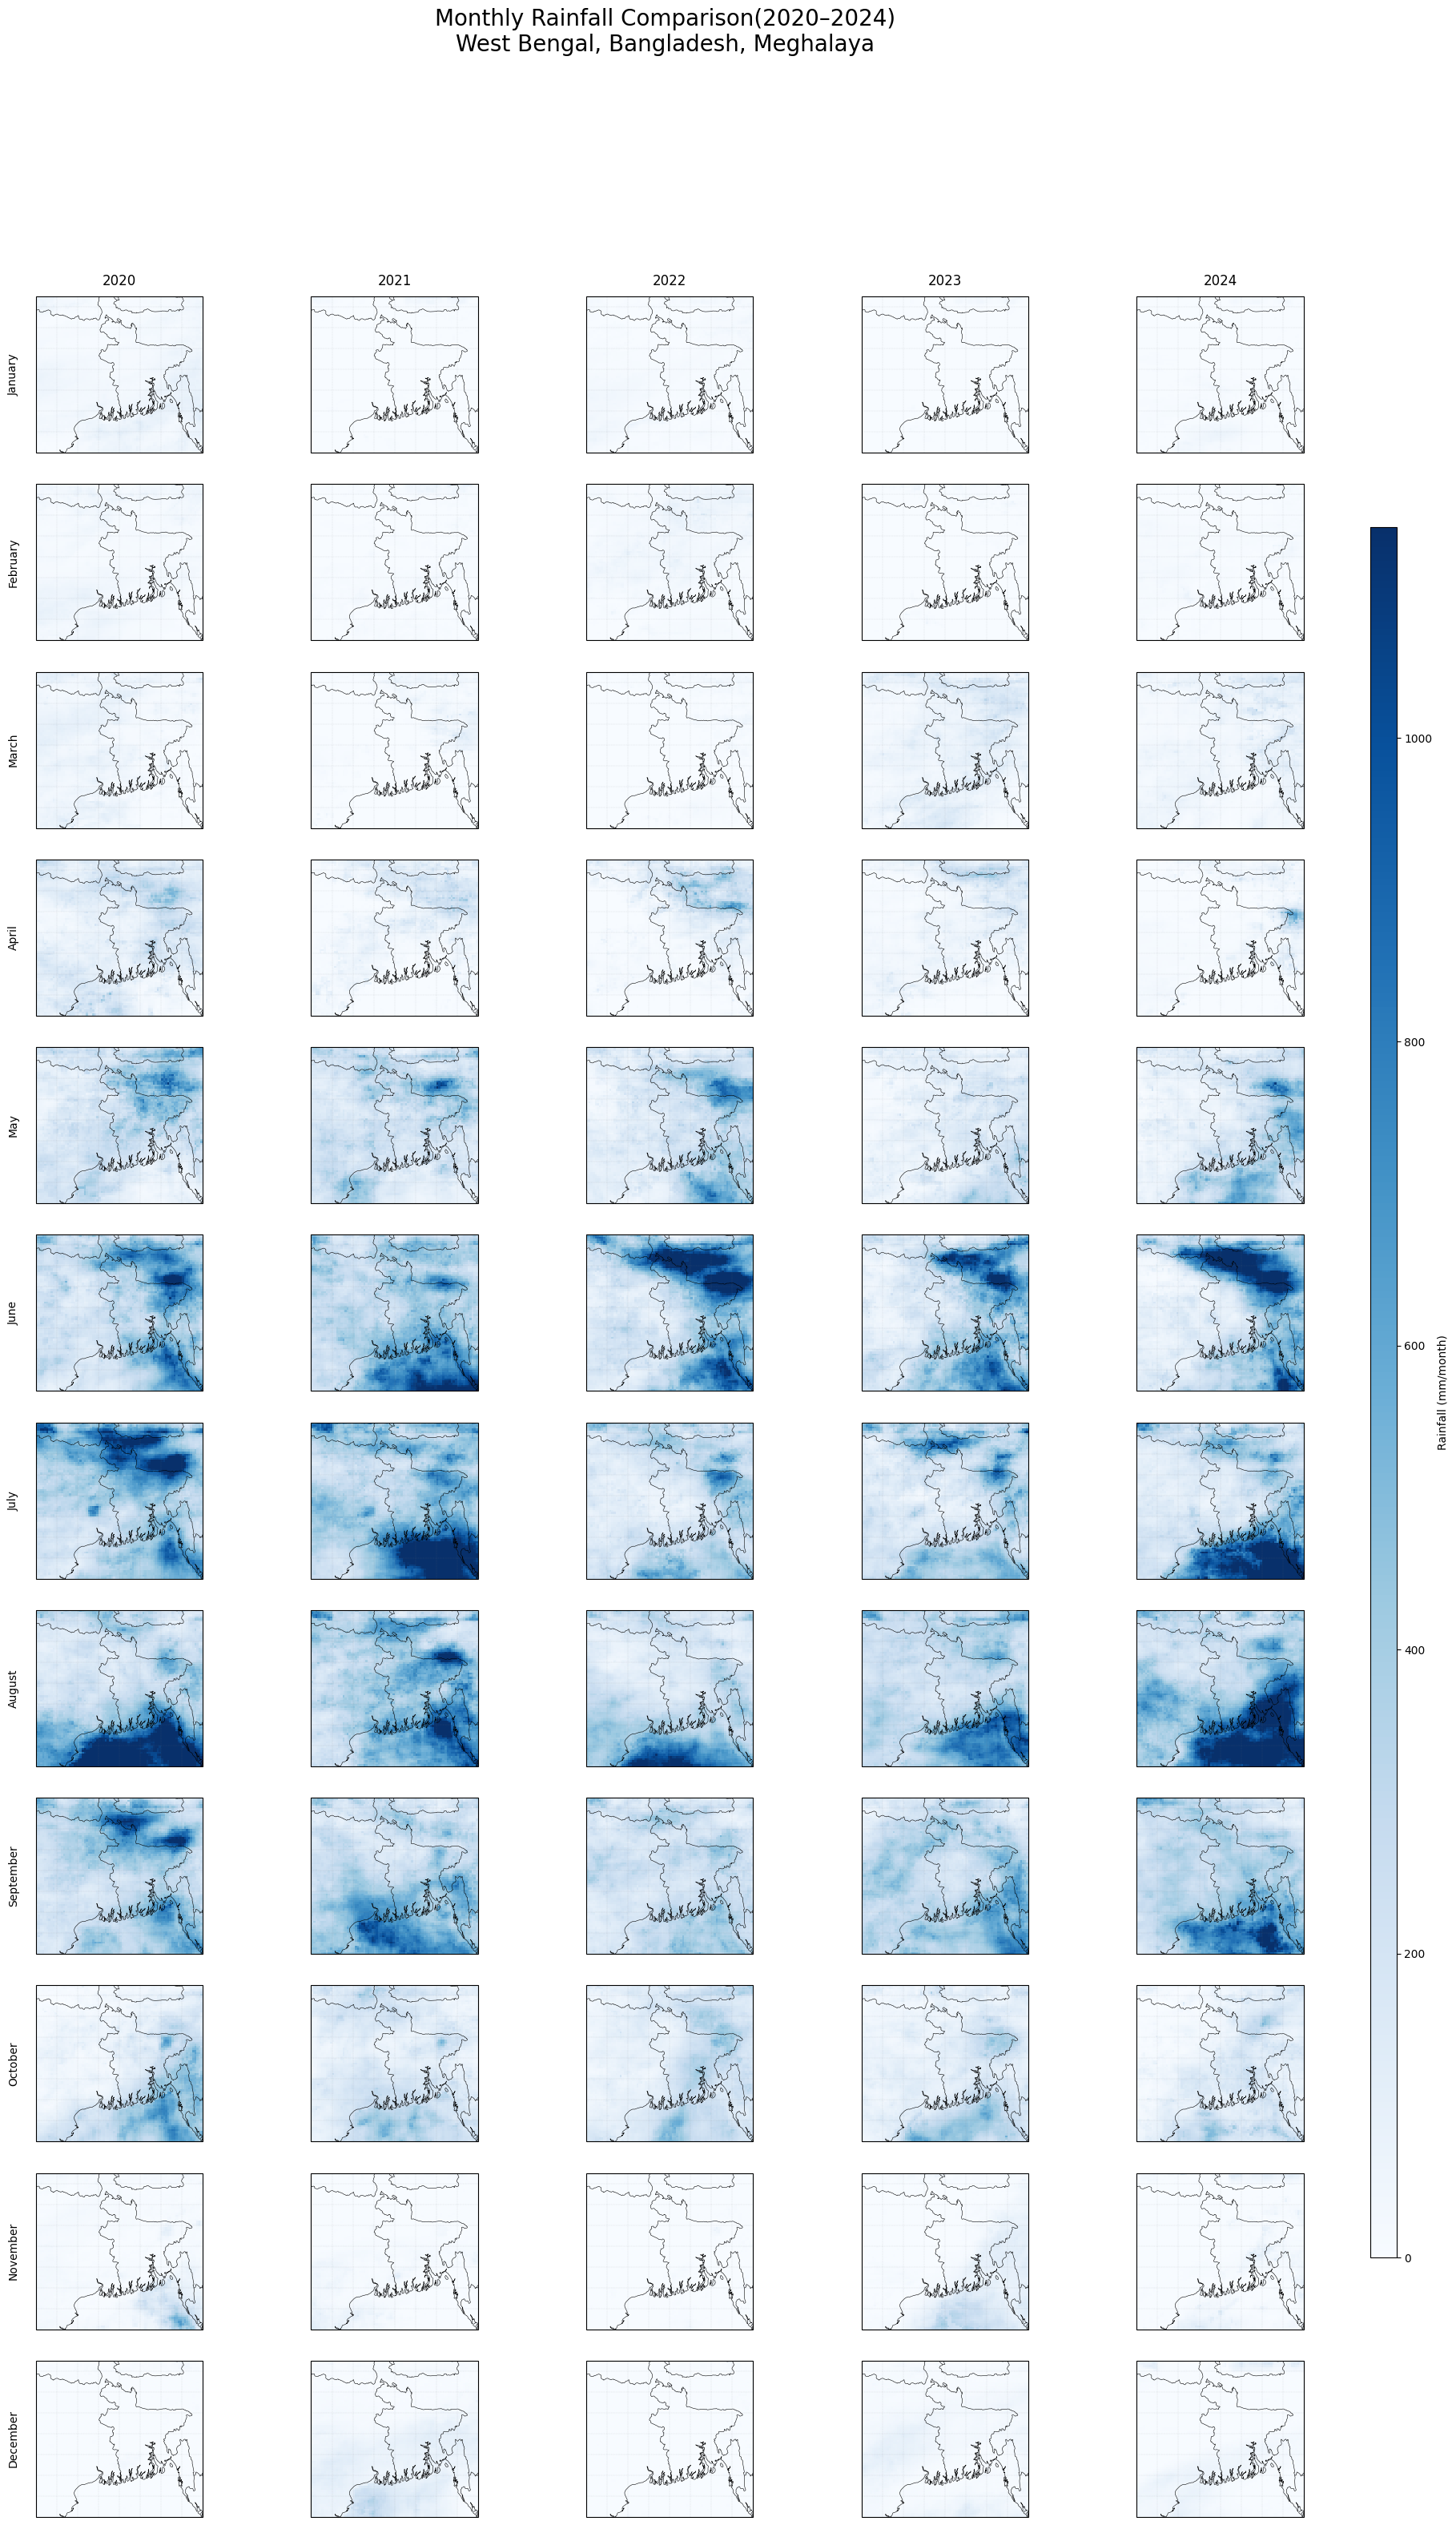

In [109]:
monthly_rain['time'] = pd.to_datetime(monthly_rain['time'].values)
years = np.arange(2020, 2025)
months = np.arange(1, 13)
flat_rain = monthly_rain.values.flatten()
flat_rain = flat_rain[~np.isnan(flat_rain)]
vmin = 0
vmax = np.percentile(flat_rain, 99)

fig, axes = plt.subplots(12, 5, figsize=(22, 36), subplot_kw={'projection': ccrs.PlateCarree()})

for i, month in enumerate(months):
    for j, year in enumerate(years):
        ax = axes[i, j]
        
        sel = monthly_rain.sel(time=((monthly_rain['time.year'] == year) & (monthly_rain['time.month'] == month)))
        if sel.time.size == 0:
            ax.set_visible(False)
            continue
        data = sel.squeeze()

        pcm = ax.pcolormesh(
            data.lon, data.lat, data,
            cmap='Blues', shading='auto',
            transform=ccrs.PlateCarree(),
            vmin=vmin, vmax=vmax
        )

        ax.set_extent([85, 93, 20, 27.5], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.BORDERS, linewidth=0.4)
        ax.add_feature(cfeature.COASTLINE, linewidth=0.4)

        if j == 0:
            month_name = calendar.month_name[month]
            ax.text(-0.1, 0.5, month_name, va='center', ha='right', fontsize=10, transform=ax.transAxes, rotation=90)

        if i == 0:
            ax.set_title(str(year), fontsize=12, pad=10)

        gl = ax.gridlines(draw_labels=False, linewidth=0.2, color='gray', alpha=0.4, linestyle='--')

plt.subplots_adjust(right=0.88, hspace=0.2)
cbar_ax = fig.add_axes([0.9, 0.2, 0.015, 0.6])
fig.colorbar(pcm, cax=cbar_ax, label='Rainfall (mm/month)')

fig.suptitle('Monthly Rainfall Comparison(2020–2024)\nWest Bengal, Bangladesh, Meghalaya', fontsize=20)
plt.show()

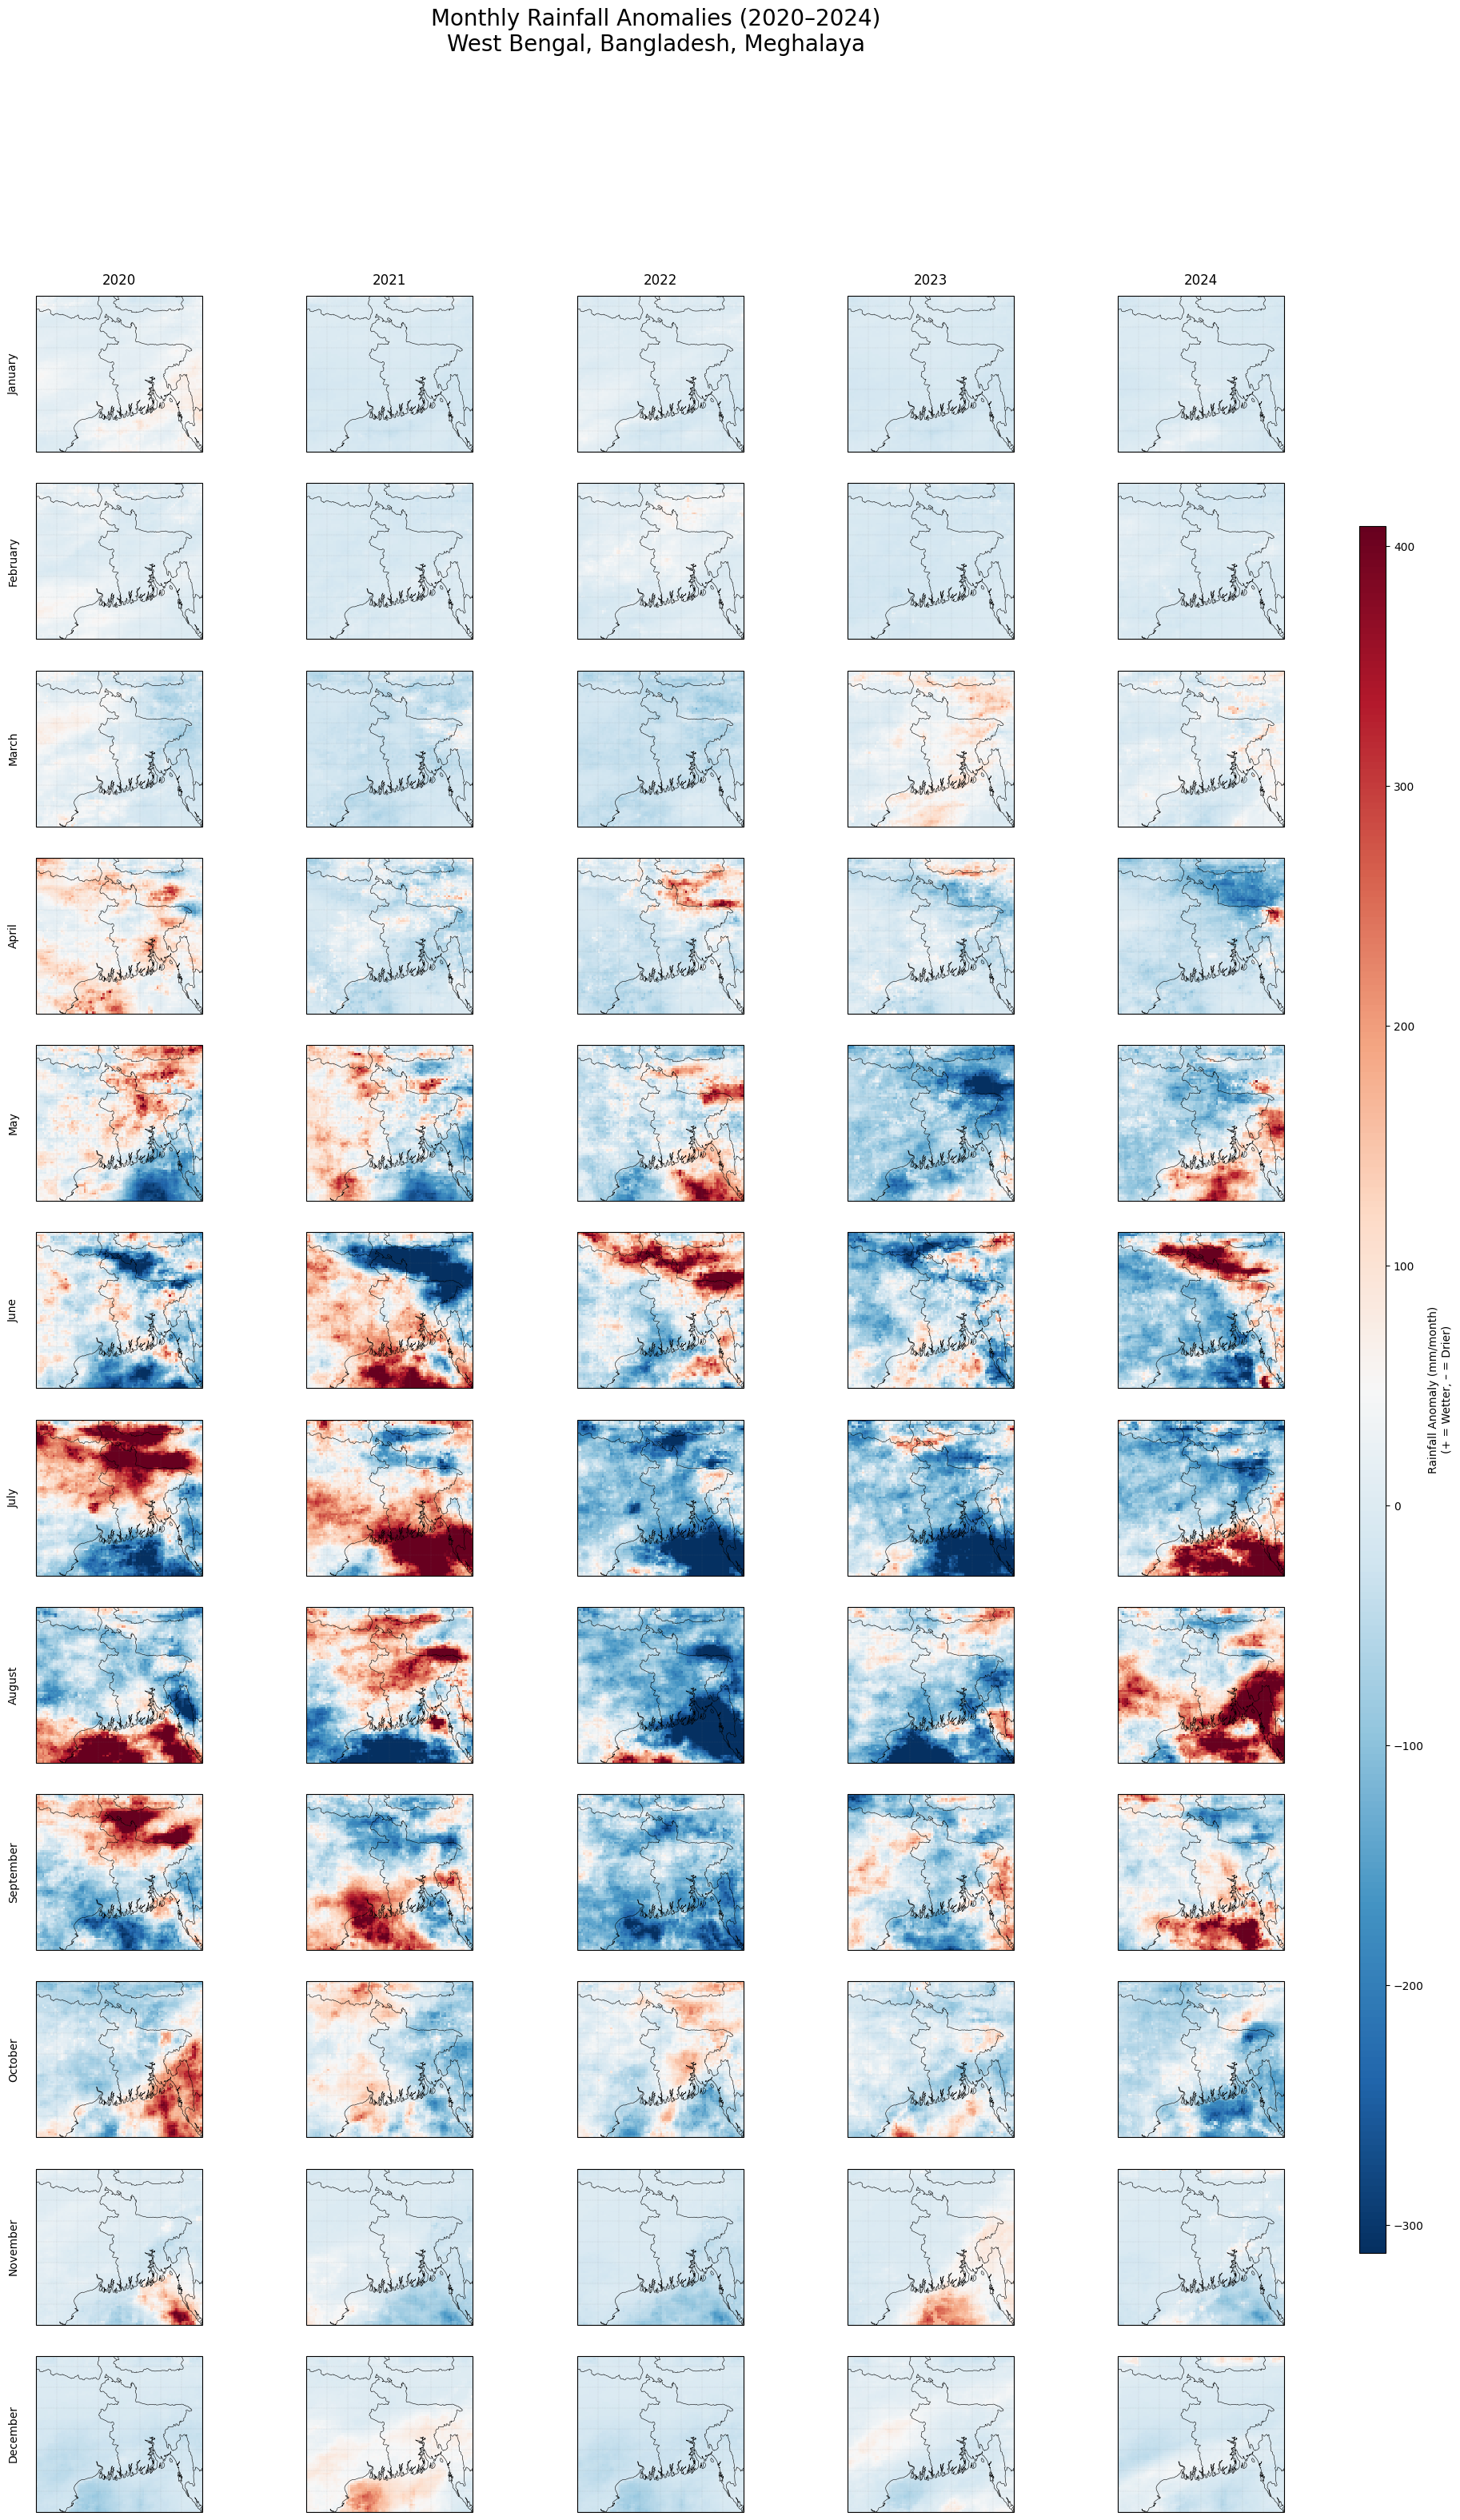

In [108]:
mean = monthly_rain.groupby('time.month').mean('time')
anomalies = monthly_rain.groupby('time.month') - mean

monthly_rain['time'] = pd.to_datetime(monthly_rain['time'].values)
years = np.arange(2020, 2025)
months = np.arange(1, 13)

fig, axes = plt.subplots(12, 5, figsize=(22, 36), subplot_kw={'projection': ccrs.PlateCarree()})
flat_anom = anomalies.values.flatten()
flat_anom = flat_anom[~np.isnan(flat_anom)]

vmin = np.percentile(flat_anom, 1)
vmax = np.percentile(flat_anom, 99)

for i, month in enumerate(months):
    for j, year in enumerate(years):
        ax = axes[i, j]

        sel = anomalies.sel(time=((anomalies['time.year'] == year) & (anomalies['time.month'] == month)))
        if sel.time.size == 0:
            ax.set_visible(False)
            continue
        data = sel.squeeze()

        pcm = ax.pcolormesh(
            data.lon, data.lat, data,
            cmap='RdBu_r', shading='auto',
            vmin=vmin, vmax=vmax,
            transform=ccrs.PlateCarree()
        )

        ax.set_extent([85, 93, 20, 27.5], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.BORDERS, linewidth=0.4)
        ax.add_feature(cfeature.COASTLINE, linewidth=0.4)

        if j == 0:
            month_name = calendar.month_name[month]
            ax.text(-0.1, 0.5, month_name, va='center', ha='right', fontsize=10, transform=ax.transAxes, rotation=90)

        if i == 0:
            ax.set_title(str(year), fontsize=12, pad=10)

        gl = ax.gridlines(draw_labels=False, linewidth=0.2, color='gray', alpha=0.4, linestyle='--')

plt.subplots_adjust(right=0.88, hspace=0.2)
cbar_ax = fig.add_axes([0.9, 0.2, 0.015, 0.6])
fig.colorbar(pcm, cax=cbar_ax, label='Rainfall Anomaly (mm/month)\n(+ = Wetter, – = Drier)')
fig.suptitle('Monthly Rainfall Anomalies (2020–2024)\nWest Bengal, Bangladesh, Meghalaya', fontsize=20)
plt.show()

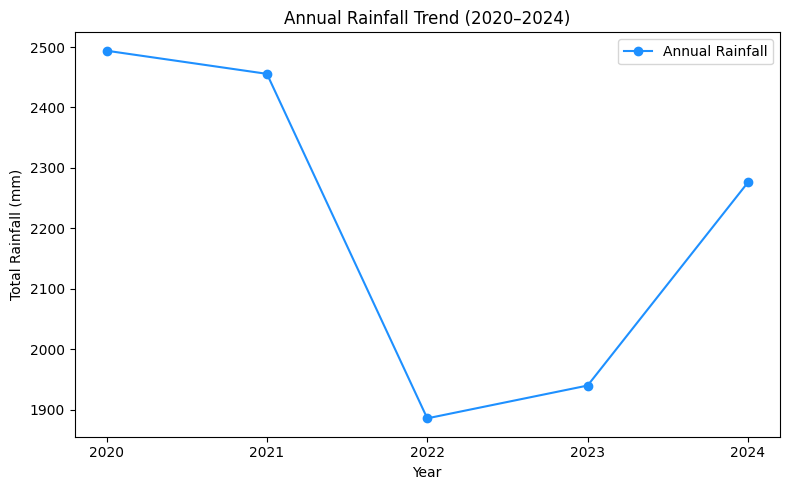

In [118]:
annual_total = monthly_rain.groupby('time.year').sum(dim='time')
annual_avg = annual_total.mean(dim=['lat', 'lon'])
years = annual_avg['year'].values
values = annual_avg.values

plt.figure(figsize=(8, 5))
plt.plot(years, values, marker='o', linestyle='-', color='dodgerblue', label='Annual Rainfall')
plt.title('Annual Rainfall Trend (2020–2024)')
plt.xticks(ticks=years, labels=[str(y) for y in years])
plt.xlabel('Year')
plt.ylabel('Total Rainfall (mm)')
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

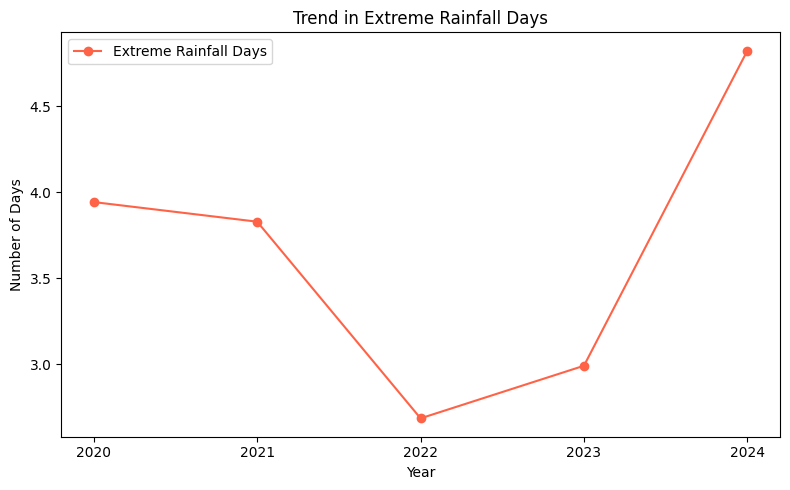

In [117]:
flat_daily = precip.values.flatten()
flat_daily = flat_daily[~np.isnan(flat_daily)]
threshold = np.percentile(flat_daily, 99)
extreme_days = (precip >= threshold).mean(dim=['lat', 'lon'])
extreme_count = extreme_days.groupby('time.year').sum()
extreme_vals = extreme_count.values

plt.figure(figsize=(8, 5))
plt.plot(years, extreme_vals, marker='o', linestyle='-', color='red', label='Extreme Rainfall Days')
plt.title('Trend in Extreme Rainfall Days')
plt.xticks(ticks=years, labels=[str(y) for y in years])
plt.xlabel('Year')
plt.ylabel('Number of Days')
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()